## Estimando o Impacto das Variáveis Externas na Inflação Brasileira

O modelo fundamental utilizado é o seguinte:

$$\pi_t^{nucleo} = \sum_{i>0} \beta_{1i} E_t \pi^{total}_{t+i} +\sum_{j>0} \beta_{2j} \pi^{nucleo}_{t-j} +\sum_{k \geq 0} \beta_{3k} \pi^{importada}_{t-k} + \sum_{l>0} \beta_{4l} hiato_{t-l} + \epsilon_t$$

Em essência, esse modelo descreve a inflação dos preços, excluindo alimentos e produtos administrados, como uma função linear de fatores como a inflação passada, as expectativas de inflação, a diferença entre a produção atual e a produção potencial, e a influência da inflação importada.

A estimação do modelo é realizada por meio do método Generalized Method of Moments (GMM).  As variáveis utilizadas no modelo são:

  - Hiato do Produto - BCB;
  
  - IC-Br USD (Var. %. Trim.) - BCB;
  
  - Expectativa de 12 meses do IPCA Total (a.a%) - BCB;
  
  - IPCA EX01 (a.a%) - BCB.


## 1. Carregamento das bibliotecas

In [2]:
!pip install python-bcb
!pip install linearmodels

In [3]:
from bcb import sgs # Importar dados do SGS
from bcb import Expectativas # Importar dados de Expectativas
import pandas as pd # Manipulação de dados
import numpy as np # Manipulação e cálculo de dados
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

## 2. Coleta e Tratamento de dados

### 2.1 Expectativas de inflação

In [4]:
# Instância a classe de expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Inflação Acumulada em 12 meses
exp_ipca_raw = em.get_endpoint('ExpectativasMercadoInflacao12Meses')

# Realiza a importação da Expectativa de Inflação Acumulada em 12 meses
exp_ipca = (
  exp_ipca_raw.query() # faz a consulta
 .filter(exp_ipca_raw.Indicador == 'IPCA') # filtra apenas para o IPCA
 .filter(exp_ipca_raw.baseCalculo == '0') # filtra a Base de Cálculo para 0
 .filter(exp_ipca_raw.Suavizada == 'S') # filtra Suavizada para S
 .collect() # faz a importação dos dados
  )

In [5]:
exp_ipca

,Indicador,Data,Suavizada,Media,Mediana,DesvioPadrao,Minimo,Maximo,numeroRespondentes,baseCalculo
0,IPCA,2001-12-12,S,5.1700,5.2200,0.5600,NaN,NaN,NaN,0
1,IPCA,2001-12-13,S,5.1600,5.2200,0.5500,NaN,NaN,NaN,0
2,IPCA,2001-12-14,S,5.1300,5.1500,0.5700,NaN,NaN,NaN,0
3,IPCA,2001-12-17,S,5.1200,5.1600,0.5700,NaN,NaN,NaN,0
4,IPCA,2001-12-18,S,5.0900,5.1300,0.5800,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
5618,IPCA,2024-05-06,S,3.6062,3.5986,0.3646,2.6445,5.3404,129.0,0
5619,IPCA,2024-05-07,S,3.6044,3.5954,0.3651,2.6435,5.3327,130.0,0
5620,IPCA,2024-05-08,S,3.6077,3.5911,0.3616,2.6424,5.3251,130.0,0
5621,IPCA,2024-05-09,S,3.6105,3.5998,0.3612,2.6414,5.3174,130.0,0


In [6]:
# Tratamento da IPCA-EX0
## Trimestraliza expectativa (média)
exp_ipca_aux = (
  exp_ipca
  # cria colunas de ano e mês para o agrupamento
 .assign(Year = lambda x: pd.to_datetime(x.Data).dt.year,
         Month = lambda x: pd.to_datetime(x.Data).dt.month)
  # agrupa por ano e mês
  .groupby(by = ['Year', 'Month'])
  # calcula a média
  .agg({'Mediana' : 'mean'})
  .reset_index()
  # cria colunas para o trimestre e cria uma coluna de data trimestral
  .assign(Quarter = lambda x: pd.to_datetime(x[['Year', 'Month']].assign(Day = 1)),
          date_quarter = lambda x: pd.PeriodIndex(x['Quarter'], freq = 'Q'))
  # agrupa por trimestre
  .groupby(by = 'date_quarter')
  # calcula a média
  .agg(ipca_exp_12m = ('Mediana', 'mean'))
  .reset_index()
)

In [7]:
exp_ipca_aux

,date_quarter,ipca_exp_12m
0,2001Q4,5.030000
1,2002Q1,4.699958
2,2002Q2,4.541706
3,2002Q3,5.062570
4,2002Q4,9.692981
...,...,...
86,2023Q2,4.822036
87,2023Q3,4.141353
88,2023Q4,3.932383
89,2024Q1,3.690813


### 2.2 IPCA-EX0

In [8]:
# Função para acumular os trimestres
def acum_quarter(x):
    """
    Acumula a variação percentual mensal em um trimestre.

    Argumentos:
    - x: lista, array ou série pandas contendo os valores de inflação.

    Retorno:
    - A inflação acumulada em um trimestre, em porcentagem.
    """

    # Transforma os valores em fatores de crescimento
    x_fac = 1 + (x / 100)

    # Calcula o produto acumulado dos últimos três valores
    x_cum = np.prod(x_fac[-3:])

    # Calcula a inflação acumulada em um trimestre
    x_qr = (x_cum - 1) * 100

    return x_qr

def acum_p(data, n):
    """
    Calcula a acumulação de variações percentuais em janelas móveis.

    Argumentos:
    - data: array-like
        Uma sequência de dados representando variações percentuais.

    - n: int
        O tamanho da janela móvel para o cálculo da acumulação.

    Retorno:
    - array
        Um array contendo a acumulação das variações percentuais em janelas móveis.
    """

    resultado = (((data / 100) + 1)
                 .rolling(window=n)
                 .apply(np.prod)
                 - 1) * 100
    return resultado

In [9]:
# Coleta e tratamento do IPCA-EX0
dados_ipca = (
    # importa o ipca total e livres do sgs
    sgs.get({'ipca_nucleo' : 11427},
        start = '1998-01-01')
    .reset_index()
    # cria coluna de data trimestral
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['Date'], freq = 'Q'))
    # agrupa por trimestre
    .groupby(by = 'date_quarter')
    # calcula o acumulado trimestral
    .agg({
        'ipca_nucleo': lambda x: acum_quarter(x)
    })
    .reset_index()
    # calcula o produto móvel de 4 trimestres
    .assign(ipca_nucleo = lambda x: acum_p(x.ipca_nucleo, n = 4))
)

In [10]:
dados_ipca

,date_quarter,ipca_nucleo
0,1998Q1,NaN
1,1998Q2,NaN
2,1998Q3,NaN
3,1998Q4,0.982808
4,1999Q1,1.395896
...,...,...
101,2023Q2,5.310332
102,2023Q3,4.692821
103,2023Q4,4.132516
104,2024Q1,3.255330


### 2.3 IC-br USD

In [11]:
# Função para acumular os trimestres
def acum_ic(x):
    """
    Calcula a variação acumulada em um determinado período da série do IC-br

    Argumentos:
    - x: lista, array ou série pandas contendo os valores do IC-br.

    Retorno:
    - A variação acumulada em um determinado período, em porcentagem.
    """

    # Calcula a variação percentual em relação ao primeiro valor de x
    x_diff = np.log(x / x.iloc[0]) * 100

    # Retorna o último valor da série x_diff
    x_acum = x_diff.iloc[-1]

    return x_acum

In [12]:
# Coleta e tratamento do IC-br USD
dados_ic = (
    # importa os dados do ic-br do sgs
    sgs.get({'ic_br' : 29042},
             start = '1998-01-01')
    .reset_index()
    # cria coluna de data trimestral
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['Date'], freq = 'Q'))
    # agrupa por trimestre
    .groupby(by = 'date_quarter')
    # calcula o acumulado trimestral
    .agg({
        'ic_br': lambda x: acum_ic(x)
    })
    .reset_index()
)

In [13]:
dados_ic

,date_quarter,ic_br
0,1998Q1,-3.910579
1,1998Q2,-5.008094
2,1998Q3,-4.150212
3,1998Q4,-3.858045
4,1999Q1,-6.631748
...,...,...
101,2023Q2,-2.126762
102,2023Q3,3.632897
103,2023Q4,-5.908328
104,2024Q1,5.281916


### 2.4 Hiato do Produto



O Hiato do Produto pode ser estimado de diferentes formas, tanto por meios estatísticos, seja através do filtro HP, Hamilton ou de Kalman, ou por meio de estimações via função de produção, este último disponibilizado os dados pela IFI e pelo BACEN, com os dados disponibilizadas pelos anexos estatísticos do Relatório de Inflação.

Para este exercício, usamos a série do BACEN, disponibilizado pelo [RI202309](https://www.bcb.gov.br/content/ri/relatorioinflacao/202309/ri202309anp.xlsx), ou seja, com dados disponibilizados até 09/2023.

In [14]:
# Coleta e tratamento do Hiato do Produto do BC
hiato = (
    # lê o arquivo direto da url
    pd.read_excel(
    "https://www.bcb.gov.br/content/ri/relatorioinflacao/202403/ri202403anp.xlsx",
    sheet_name = "Graf 2.2.4",
    skiprows = 8
    )
    # altera o tipo de dado da coluna de data e do hiato
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['Trimestre'], freq = 'Q'),
            hiato = lambda x: x.Hiato.astype(float))
    .loc[:, ['date_quarter', 'hiato']]
  )

In [15]:
hiato

,date_quarter,hiato
0,NaT,NaN
1,2003Q4,-0.83
2,2004Q1,-0.40
3,2004Q2,-0.03
4,2004Q3,0.35
...,...,...
78,2023Q1,-0.61
79,2023Q2,-0.64
80,2023Q3,-0.66
81,2023Q4,-0.60


### 2.5 Reunir os dados e criar defasagens

In [16]:
# lista de dataframes
dfs = [dados_ipca, dados_ic, hiato, exp_ipca_aux]

# reduz os dataframes pela chave 'date_quarter' com left join
dados_reg = reduce(lambda left, right: pd.merge(left, right, on = 'date_quarter', how = 'left'), dfs).dropna()

# Altera o tipo de dado da coluna de data para poder plotar
dados_reg['date_quarter'] = pd.to_datetime(dados_reg['date_quarter'].dt.strftime('%m-%Y'))

In [17]:
dados_reg

,date_quarter,ipca_nucleo,ic_br,hiato,ipca_exp_12m
23,2003-12-01,8.163912,4.134817,-0.83,6.043076
24,2004-03-01,7.087708,6.461361,-0.40,5.656867
25,2004-06-01,7.151717,1.186196,-0.03,5.739341
26,2004-09-01,7.493640,1.806028,0.35,6.193146
27,2004-12-01,7.933131,1.452124,0.63,6.095725
...,...,...,...,...,...
100,2023-03-01,7.341027,-4.661394,-0.61,5.502346
101,2023-06-01,5.310332,-2.126762,-0.64,4.822036
102,2023-09-01,4.692821,3.632897,-0.66,4.141353
103,2023-12-01,4.132516,-5.908328,-0.60,3.932383


c:\Users\pedro\anaconda3\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


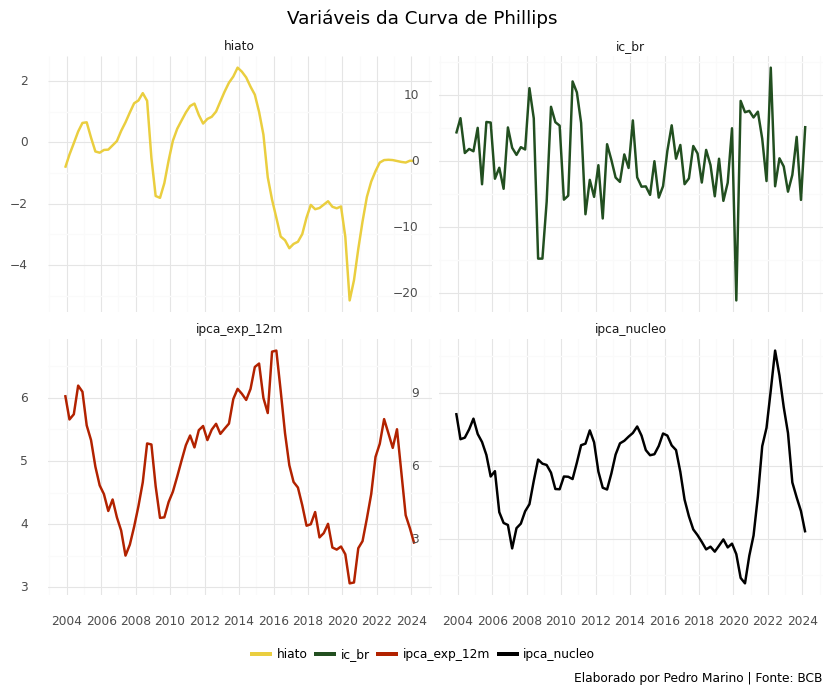

<ggplot: (89527703986)>

In [18]:
# Verifica as variáveis
## passa para o formato long
dados_reg_long = dados_reg.melt(id_vars = ['date_quarter'])

## Cria o gráfico
from plotnine import *

(
  ggplot(dados_reg_long, aes(x = 'date_quarter', y = 'value', color = 'variable')) +
  geom_line(size =  1) +
  theme_minimal() +
  facet_wrap('variable', scales = 'free_y') +
  scale_color_manual(values = ['#eace3f', '#224f20', '#b22200', 'black', "#666666"]) +
  scale_x_datetime(date_breaks = '2 years', date_labels = "%Y") +
  labs(
    title = 'Variáveis da Curva de Phillips',
    x = '',
    y = '',
    color = "",
    caption = 'Elaborado por Pedro Marino | Fonte: BCB')+
  theme(legend_position = 'bottom',
        figure_size = (10, 7))
  )

In [19]:
# Calcula as defasagens
dados_reg['ipca_nucleo_lag1'] = dados_reg['ipca_nucleo'].shift(1)
dados_reg['hiato_lag1'] = dados_reg['hiato'].shift(1)
dados_reg['ic_br_lag1'] = dados_reg['ic_br'].shift(1)

# Retira dados faltantes
dados_reg.dropna(inplace = True)

In [20]:
dados_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 24 to 104
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_quarter      81 non-null     datetime64[ns]
 1   ipca_nucleo       81 non-null     float64       
 2   ic_br             81 non-null     float64       
 3   hiato             81 non-null     float64       
 4   ipca_exp_12m      81 non-null     float64       
 5   ipca_nucleo_lag1  81 non-null     float64       
 6   hiato_lag1        81 non-null     float64       
 7   ic_br_lag1        81 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 5.7 KB


## 3. Estimação do Modelo

### 3.1 Ajuste do Modelo

In [21]:
from linearmodels import IVGMM

# estima o modelo via formula
eq_phillips = IVGMM.from_formula('ipca_nucleo ~  -1 + ipca_nucleo_lag1 + ipca_exp_12m + hiato_lag1 + ic_br_lag1', data = dados_reg).fit()

# Sumário do modelo
print(eq_phillips.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:            ipca_nucleo   R-squared:                      0.9886
Estimator:                     IV-GMM   Adj. R-squared:                 0.9880
No. Observations:                  81   F-statistic:                    9508.1
Date:                Wed, May 15 2024   P-value (F-stat)                0.0000
Time:                        11:12:36   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
hiato_lag1           0.1060     0.0330     3.2116     0.0013      0.0413      0.1707
ic_br_lag1           0.0478 

### 3.2 Verifica os resultados

In [22]:
# Cria um DataFrame pandas com os dados da regressão
phillips_fit = pd.DataFrame({'date': dados_reg['date_quarter'],
                             'Modelo': eq_phillips.fitted_values.fitted_values,
                             "IPCA EX0" : dados_reg['ipca_nucleo'],
                             "Desvio" : dados_reg.ipca_nucleo -  eq_phillips.fitted_values.fitted_values,
                             "Resíduo" : eq_phillips.resids,
                             "ipca_nucleo_lag1": eq_phillips.params.ipca_nucleo_lag1 * dados_reg.ipca_nucleo_lag1,
                             "ipca_exp_12m": eq_phillips.params.ipca_exp_12m * dados_reg.ipca_exp_12m,
                             "hiato_lag1": eq_phillips.params.hiato_lag1 * dados_reg.hiato_lag1,
                             "ic_br_lag1": eq_phillips.params.ic_br_lag1 * dados_reg.ic_br_lag1})

In [23]:
phillips_fit

,date,Modelo,IPCA EX0,Desvio,Resíduo,ipca_nucleo_lag1,ipca_exp_12m,hiato_lag1,ic_br_lag1
24,2004-03-01,7.866548,7.087708,-0.778840,-0.778840,6.262387,1.494590,-0.088010,0.197582
25,2004-06-01,7.219572,7.151717,-0.067854,-0.067854,5.436851,1.516380,-0.042415,0.308755
26,2004-09-01,7.175731,7.493640,0.317909,0.317909,5.485951,1.636279,-0.003181,0.056682
27,2004-12-01,7.482187,7.933131,0.450944,0.450944,5.748234,1.610539,0.037113,0.086301
28,2005-03-01,7.691296,7.302385,-0.388911,-0.388911,6.085359,1.469744,0.066803,0.069390
...,...,...,...,...,...,...,...,...,...
100,2023-03-01,7.796468,7.341027,-0.455441,-0.455441,6.444981,1.453764,-0.061501,-0.040775
101,2023-06-01,6.617762,5.310332,-1.307430,-1.307430,5.631167,1.274021,-0.064682,-0.222744
102,2023-09-01,4.998147,4.692821,-0.305325,-0.305325,4.073458,1.094179,-0.067863,-0.101627
103,2023-12-01,4.742358,4.132516,-0.609842,-0.609842,3.599777,1.038967,-0.069984,0.173597


#### 3.2.1 Ajuste do Modelo

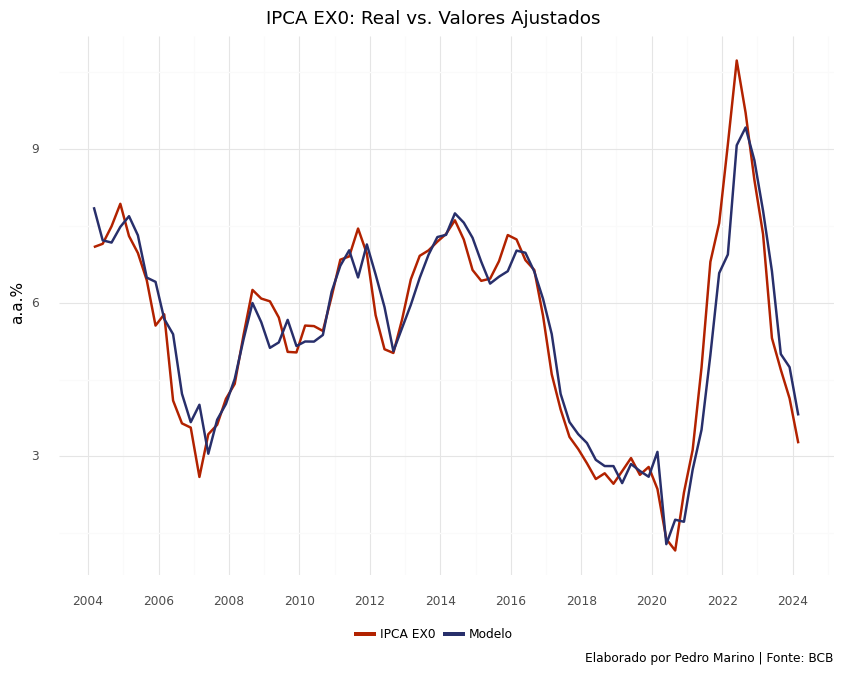

<ggplot: (89531252986)>

In [24]:
# Altera para long
phillips_fit_long = phillips_fit[['date', 'Modelo', 'IPCA EX0']].melt(id_vars = ['date'])

# Criação do gráfico
(
  ggplot(phillips_fit_long, aes(x = 'date', y = 'value', color = 'variable')) +
  geom_line(size =  1) +
  theme_minimal() +
  scale_color_manual(values = ['#b22200', '#282f6b']) +
  scale_x_datetime(date_breaks = '2 years', date_labels = "%Y") +
  labs(
    title = 'IPCA EX0: Real vs. Valores Ajustados',
    x = '',
    y = 'a.a.%',
    color = "",
    caption = 'Elaborado por Pedro Marino | Fonte: BCB')+
  theme(legend_position = 'bottom',
        figure_size = (10, 7))
  )

#### 3.2.2 Resíduos

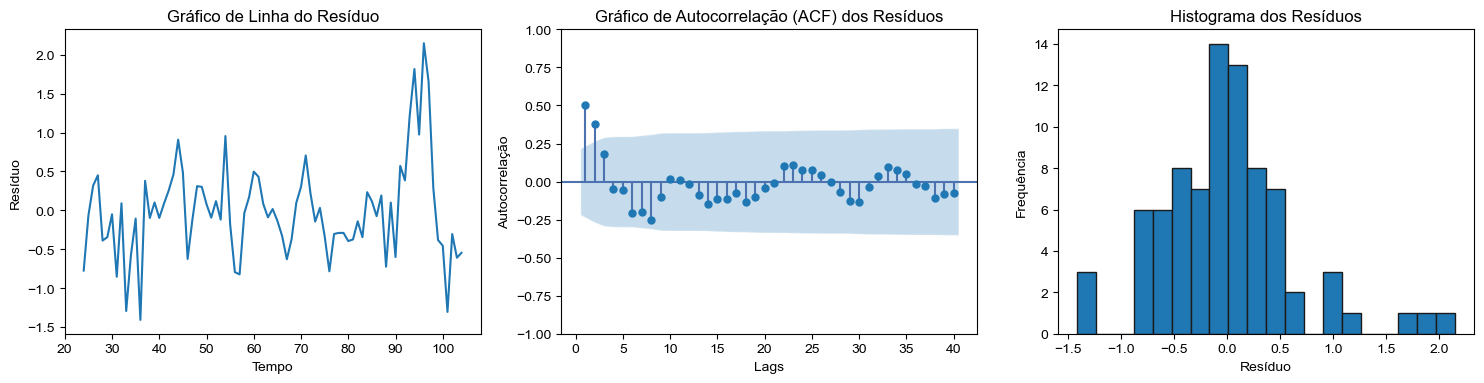

In [25]:
import statsmodels.api as sm

# Cria uma figura com 1 linha e 3 colunas para os três gráficos
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
sns.set()

# Gráfico de Linha do Resíduo
axes[0].plot(phillips_fit.Resíduo)
axes[0].set_title('Gráfico de Linha do Resíduo')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Resíduo')

# Gráfico de Autocorrelação (ACF)
sm.graphics.tsa.plot_acf(phillips_fit.Resíduo, lags=40, ax=axes[1], zero = False)
axes[1].set_title('Gráfico de Autocorrelação (ACF) dos Resíduos')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Autocorrelação')

# Gráfico de Histograma
axes[2].hist(phillips_fit.Resíduo, bins=20, edgecolor='k')
axes[2].set_title('Histograma dos Resíduos')
axes[2].set_xlabel('Resíduo')
axes[2].set_ylabel('Frequência')

plt.tight_layout()  # Para garantir que os gráficos não se sobreponham
plt.show()

#### 3.2.3 Contribuição das variáveis

In [26]:
# Seleciona as colunas para o gráfico
phillips_fit_plot = phillips_fit[['date', 'ipca_nucleo_lag1', 'ipca_exp_12m', 'hiato_lag1', 'ic_br_lag1', 'Resíduo']].set_index('date', drop = True)

# Altera o tipo de dado dataS
phillips_fit_plot.index = pd.PeriodIndex(phillips_fit_plot.index, freq = 'Q')

In [27]:
phillips_fit_plot_long = phillips_fit[['date', 'ipca_nucleo_lag1', 'ipca_exp_12m', 'hiato_lag1', 'ic_br_lag1', 'Resíduo']].melt(id_vars = ['date'])

phillips_fit_plot_long

,date,variable,value
0,2004-03-01,ipca_nucleo_lag1,6.262387
1,2004-06-01,ipca_nucleo_lag1,5.436851
2,2004-09-01,ipca_nucleo_lag1,5.485951
3,2004-12-01,ipca_nucleo_lag1,5.748234
4,2005-03-01,ipca_nucleo_lag1,6.085359
...,...,...,...
400,2023-03-01,Resíduo,-0.455441
401,2023-06-01,Resíduo,-1.307430
402,2023-09-01,Resíduo,-0.305325
403,2023-12-01,Resíduo,-0.609842


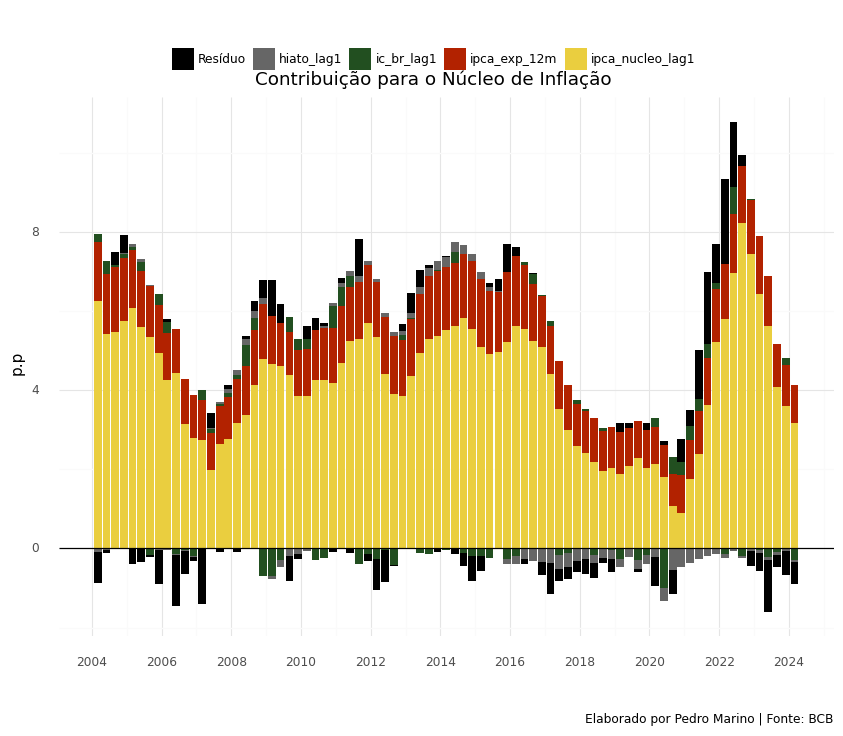

<ggplot: (89532429575)>

In [28]:
(
 ggplot(phillips_fit_plot_long, aes(x = 'date', y = 'value', fill = 'variable'))+
 geom_col() +
 geom_hline(yintercept = 0, colour = 'black') +
 theme_minimal() +
 scale_fill_manual(values = ['black', "#666666", '#224f20', '#b22200', '#eace3f']) +
 scale_x_datetime(date_breaks = '2 years', date_labels = "%Y") +
 labs(
    title = 'Contribuição para o Núcleo de Inflação',
    x = '',
    y = 'p.p',
    fill = "",
    caption = 'Elaborado por Pedro Marino | Fonte: BCB')+
  theme(legend_position = 'top',
        figure_size = (10, 7))
  )